In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from tifffile import imread
import os, sys
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from scipy.stats import zscore

5 genes, 8 tiles each    
ch03: transcripts

In [2]:
ppath = '/stanley/WangLab/Connie/02.TEMPOmap/05.revisionQuantification/20221102 ER gene in FUCCI cell HCR test 2'
nucl_seg_path = os.path.join(ppath, 'nucleus_seg')
cell_seg_path = os.path.join(ppath, 'cell_seg')
prefix = '20221102 ER gene in FUCCI cell HCR test 2_'
nucl_seg_suffix = '_RAW_ch00_nucleus_seg.tiff'
cell_seg_suffix = '_RAW_ch03_cell_seg.tiff'
mKO_suffix = '_RAW_ch01.tif'
mAG_suffix = '_RAW_ch02.tif'
spot_suffix = '_RAW_ch03.tif'

In [3]:
genes = ['ACTB', 'DAG', 'MKI67', 'TMEM43', 'TTYH3']
tiles = range(1, 9)

# FUCCI

In [101]:
fucci = []
for g in genes:
    for t in tiles:
        nucl_seg = imread(os.path.join(nucl_seg_path, f'{prefix}{g}_{t}{nucl_seg_suffix}'))
        # fig = plt.figure()
        # plt.imshow(nucl_seg)
        mAG = imread(os.path.join(ppath, g, f'tile{t}', f'{prefix}{g}_{t}{mAG_suffix}'))
        # fig = plt.figure()
        # plt.imshow(mAG)
        mKO = imread(os.path.join(ppath, g, f'tile{t}', f'{prefix}{g}_{t}{mKO_suffix}'))
        rp = regionprops(nucl_seg)
        for i in rp:
            curr_seg = nucl_seg==i.label
            nucl_area = i.area
            curr_mAG = np.sum(mAG[curr_seg])
            curr_mKO = np.sum(mKO[curr_seg])
            # fig = plt.figure()
            # plt.imshow(nucl_seg*curr_seg)
            fucci.append([g, nucl_area, curr_mAG, curr_mKO, t, i.label])

In [102]:
df = pd.DataFrame(fucci, columns=['gene', 'area', 'mAG', 'mKO', 'tile', 'cell_label'])
df['mAG_norm'] = zscore(df['mAG'] / df['area'])
df['mKO_norm'] = zscore(df['mKO'] / df['area'])
df

,gene,area,mAG,mKO,tile,cell_label,mAG_norm,mKO_norm
0,ACTB,854,884,11982,1,1,-0.918054,-2.178683
1,ACTB,1900,2385,59386,1,2,-0.905090,-0.510974
2,ACTB,1360,1051,44301,1,3,-0.933503,-0.383323
3,ACTB,2688,73562,103670,1,4,0.632639,0.196945
4,ACTB,2062,2333,55374,1,5,-0.912383,-0.937094
...,...,...,...,...,...,...,...,...
4250,TTYH3,1905,2393,64147,8,130,-0.905037,-0.276950
4251,TTYH3,2545,78022,66133,8,131,0.826399,-1.021233
4252,TTYH3,2565,18214,88888,8,132,-0.560832,-0.181951
4253,TTYH3,2345,30965,79890,8,133,-0.201379,-0.238682


<AxesSubplot:xlabel='mKO', ylabel='mAG'>

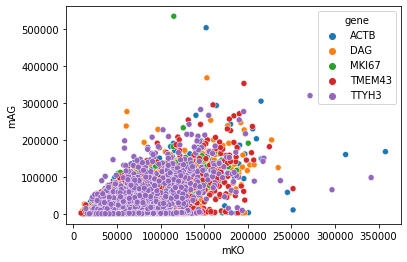

In [103]:
sns.scatterplot(data=df, x='mKO', y='mAG', hue='gene')

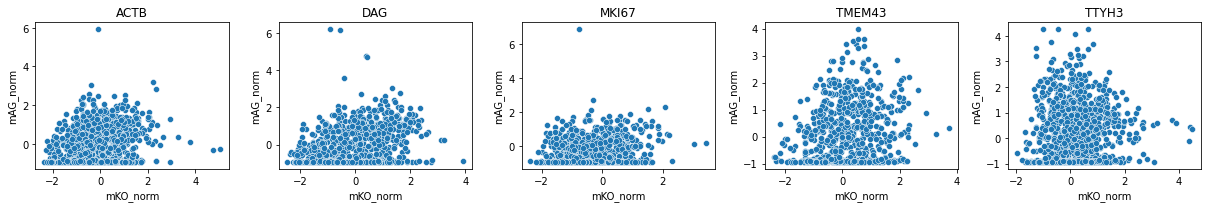

In [104]:
fig, ax = plt.subplots(1, 5, figsize=(17,3))
for i, g in enumerate(genes):
    sns.scatterplot(data=df[df['gene']==g], x='mKO_norm', y='mAG_norm', ax=ax[i]).set_title(g)
plt.tight_layout()

## set threshold for G1

In [105]:
# threshold for G1 cells
mKO_thres = 0 # less than
mAG_thres = 0 # less than

<AxesSubplot:title={'center':'MKI67'}, xlabel='mKO_norm', ylabel='mAG_norm'>

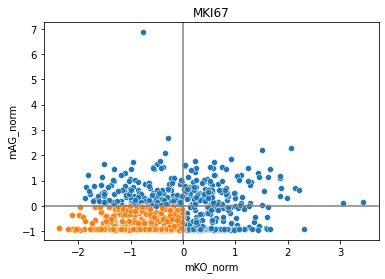

In [110]:
# raw image for G1 cells
test_gene = 'MKI67'
sns.scatterplot(data=df[df['gene']==test_gene], x='mKO_norm', y='mAG_norm').set_title(test_gene)
plt.axvline(mKO_thres, c='grey')
plt.axhline(mAG_thres, c='grey')
# optional
_g1 = df[df['gene']==test_gene]
_g1 = _g1[np.logical_and(_g1['mKO_norm']<mKO_thres, _g1['mAG_norm']<mAG_thres)]
sns.scatterplot(data=_g1[_g1['gene']==test_gene], x='mKO_norm', y='mAG_norm')

In [111]:
_g1

,gene,area,mAG,mKO,tile,cell_label,mAG_norm,mKO_norm
1697,MKI67,2383,2676,58572,1,5,-0.912882,-1.157392
1703,MKI67,2259,1726,72841,1,11,-0.934018,-0.415221
1704,MKI67,2535,2758,86247,1,12,-0.914942,-0.243111
1707,MKI67,2221,5451,77829,1,15,-0.834478,-0.144373
1709,MKI67,1175,1202,32533,1,17,-0.918769,-0.856431
...,...,...,...,...,...,...,...,...
2449,MKI67,1449,1580,35151,8,99,-0.914798,-1.188403
2452,MKI67,1678,2095,38217,8,102,-0.905488,-1.332029
2453,MKI67,1962,1720,41181,8,103,-0.927386,-1.504947
2455,MKI67,2025,2206,41349,8,105,-0.914859,-1.560137


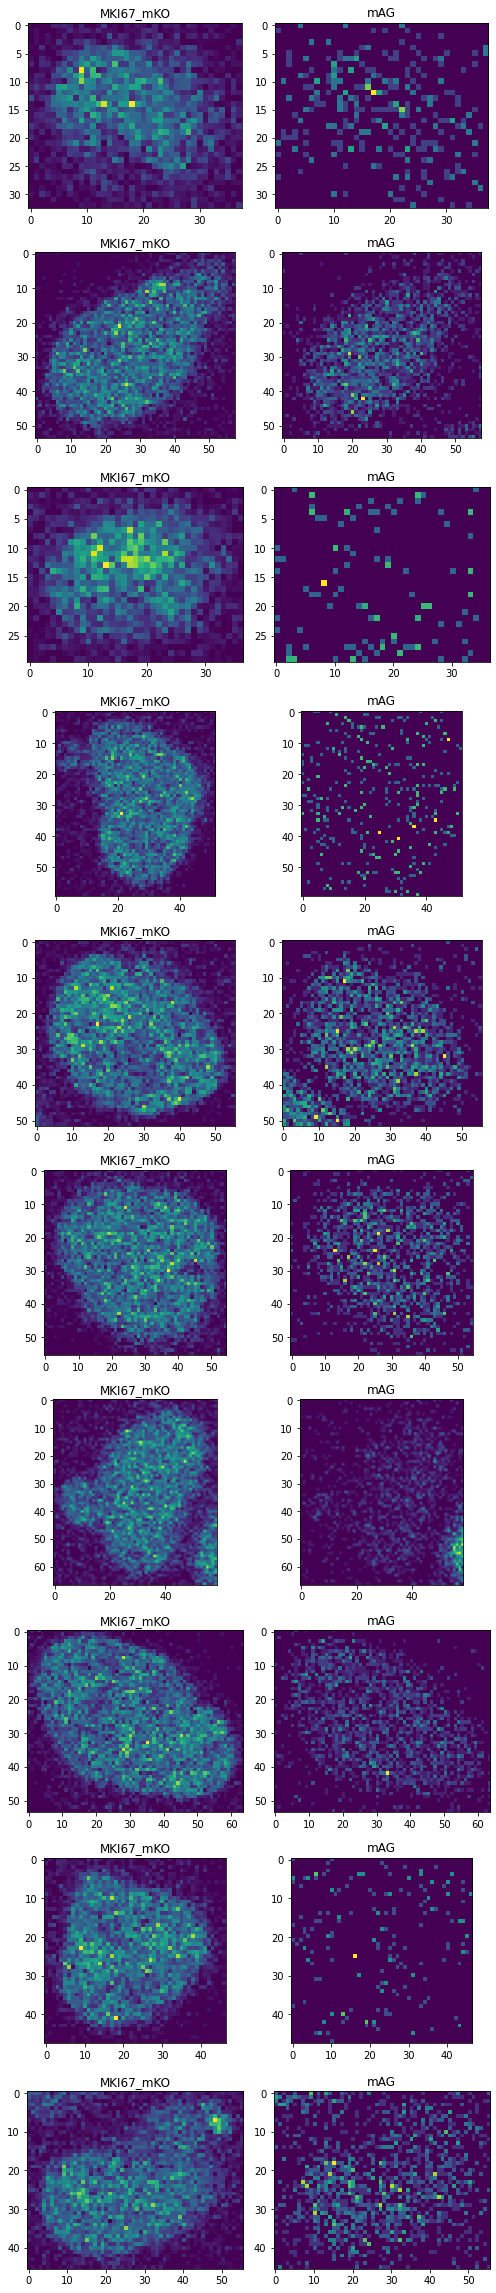

In [112]:
# randomly select
n = 10
fig, ax = plt.subplots(n,2, figsize=(7,n*3+2))
test = np.random.choice(_g1.index, size=n)
for i, t in enumerate(test):
    gene = _g1.loc[t]['gene']
    tile = _g1.loc[t]['tile']
    cell_label = _g1.loc[t]['cell_label']
    nucl_seg = imread(os.path.join(nucl_seg_path, f'{prefix}{gene}_{tile}{nucl_seg_suffix}'))
    mAG = imread(os.path.join(ppath, gene, f'tile{tile}', f'{prefix}{gene}_{tile}{mAG_suffix}'))
    mKO = imread(os.path.join(ppath, gene, f'tile{tile}', f'{prefix}{gene}_{tile}{mKO_suffix}'))
    rp = regionprops(nucl_seg)
    for _rp in rp:
        if _rp.label == cell_label:
            bbox = _rp.bbox
            _mKO = mKO[bbox[0]:bbox[2], bbox[1]:bbox[3]]
            _mAG = mAG[bbox[0]:bbox[2], bbox[1]:bbox[3]]
            ax[i,0].imshow(_mKO)
            ax[i,0].set_title(f'{gene}_mKO')
            ax[i,1].imshow(_mAG)
            ax[i,1].set_title('mAG')
plt.tight_layout()

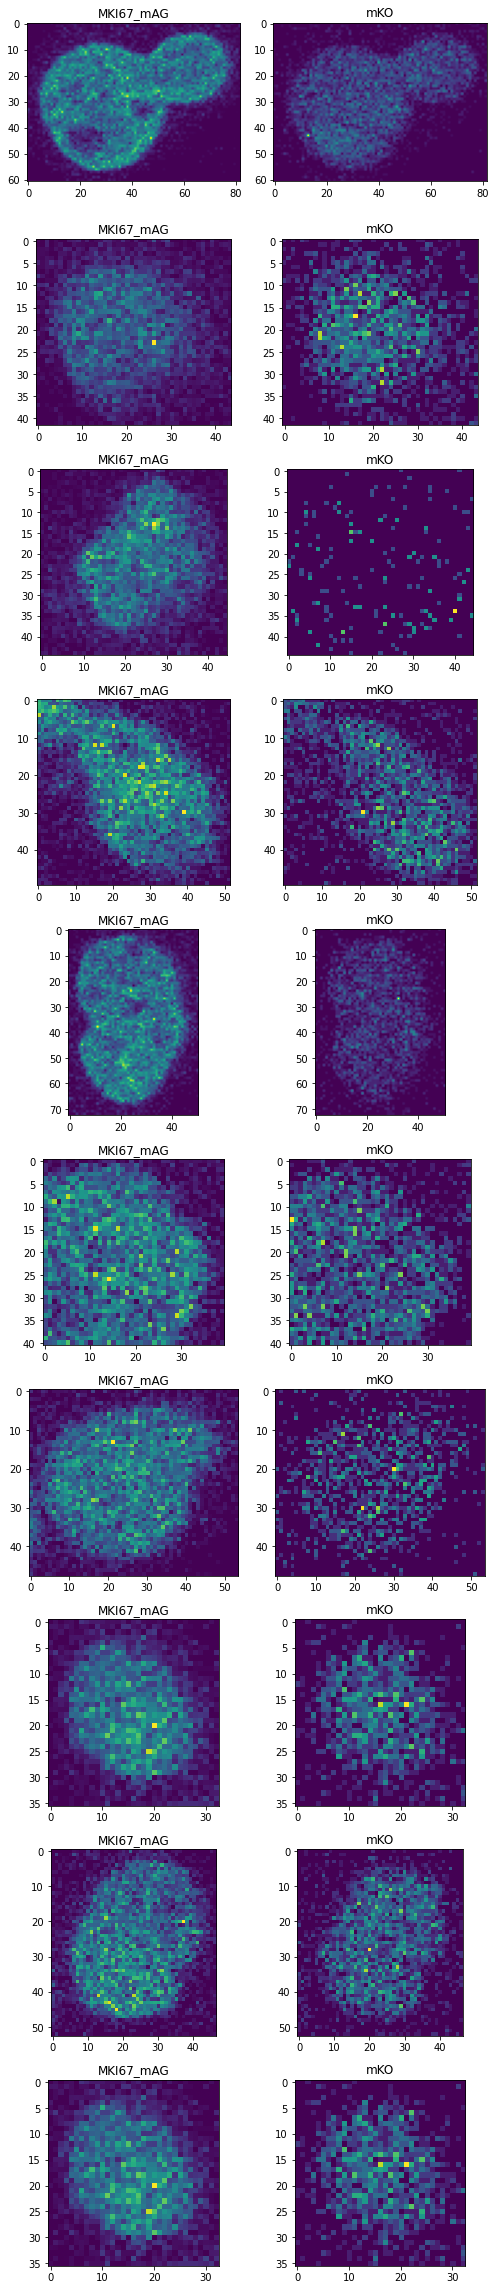

In [113]:
# randomly select (non G1 cells)
_nong1 = df[df['gene']==test_gene]
_nong1 = _nong1[np.logical_or(_nong1['mKO_norm']>=mKO_thres, _nong1['mAG_norm']>=mAG_thres)]
# n = 10
fig, ax = plt.subplots(n,2, figsize=(7,n*3+2))
test = np.random.choice(_nong1.index, size=n)
for i, t in enumerate(test):
    gene = _nong1.loc[t]['gene']
    tile = _nong1.loc[t]['tile']
    cell_label = _nong1.loc[t]['cell_label']
    nucl_seg = imread(os.path.join(nucl_seg_path, f'{prefix}{gene}_{tile}{nucl_seg_suffix}'))
    mAG = imread(os.path.join(ppath, gene, f'tile{tile}', f'{prefix}{gene}_{tile}{mAG_suffix}'))
    mKO = imread(os.path.join(ppath, gene, f'tile{tile}', f'{prefix}{gene}_{tile}{mKO_suffix}'))
    rp = regionprops(nucl_seg)
    for _rp in rp:
        if _rp.label == cell_label:
            bbox = _rp.bbox
            _mKO = mKO[bbox[0]:bbox[2], bbox[1]:bbox[3]]
            _mAG = mAG[bbox[0]:bbox[2], bbox[1]:bbox[3]]
            ax[i,0].imshow(_mKO)
            ax[i,0].set_title(f'{gene}_mAG')
            ax[i,1].imshow(_mAG)
            ax[i,1].set_title('mKO')
plt.tight_layout()

# spot finding

In [69]:
for g in genes:
    for t in tiles:
        spots_im = imread(os.path.join(ppath, g, f'tile{t}', f'{prefix}{g}_{t}{spot_suffix}'))
        cell_seg = imread(os.path.join(cell_seg_path, f'{prefix}{g}_{t}{cell_seg_suffix}'))
        spots_im[cell_seg==0] = 0
        # plt.imshow(spots)
        spots = peak_local_max(spots_im, threshold_abs=200, min_distance=5)
        spots = pd.DataFrame(spots)
        # spots.to_csv(os.path.join(ppath, 'spots_found', f'{g}_tile{t}_spots.csv'))

### test

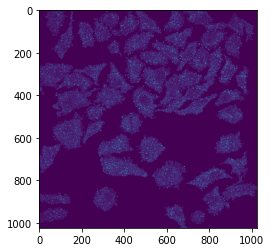

In [65]:
plt.imshow(spots_im)

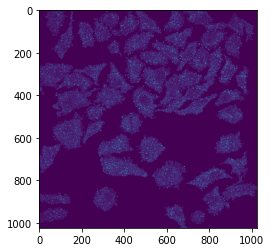

In [66]:
spots_im[cell_seg==0]=0
plt.imshow(spots_im)

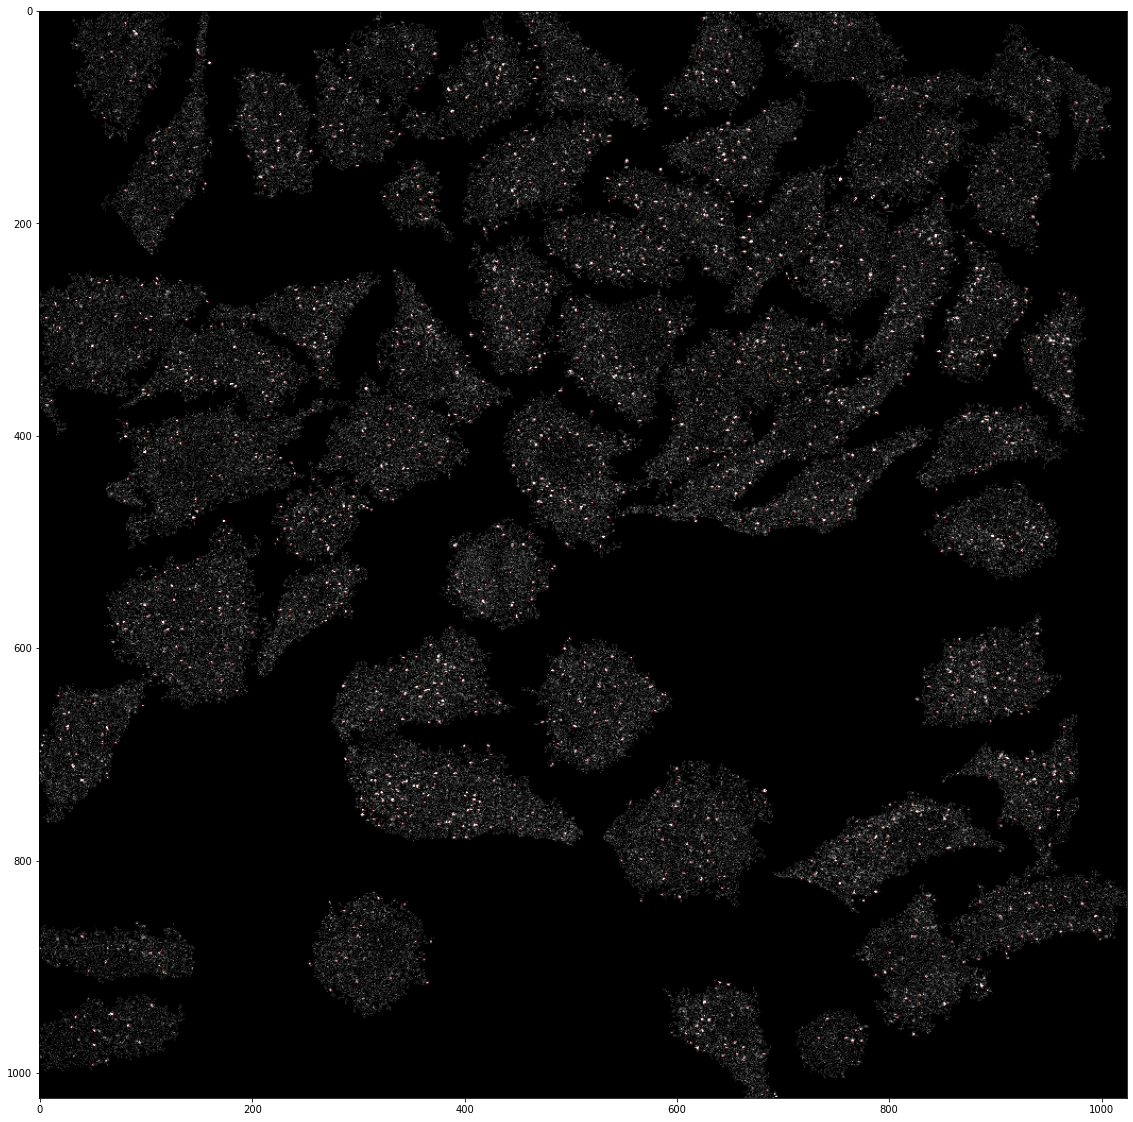

In [67]:
# test
plt.figure(figsize=(20,20))
plt.imshow(spots_im, cmap='gray')
plt.scatter(spots[:,1], spots[:,0], c='red', s=0.5, alpha=0.5)

# DR

In [4]:
from scipy.ndimage import distance_transform_edt as dt

In [ ]:
# TODO check cell.image, label, rdt, spots
# TODO output csv per gene (5*8) [gene, tile, cell_label, g1, dr]*reads (tile and cell label for retriving info of fucci)

In [14]:
for g in genes:
    for t in tiles:
        dr = []
        cell_seg = imread(os.path.join(cell_seg_path, f'{prefix}{g}_{t}{cell_seg_suffix}'))
        nucl_seg = imread(os.path.join(nucl_seg_path, f'{prefix}{g}_{t}{nucl_seg_suffix}'))
        spots = pd.read_csv(os.path.join(ppath, 'spots_found', f'{g}_tile{t}_spots.csv'), index_col=0)
        rp = regionprops(cell_seg)
        rtc = cell_seg[spots['1'], spots['0']] # note order
        rtn = nucl_seg[spots['1'], spots['0']]
        for cell in rp:
            cb = cell.bbox
            cell_mask = cell.image
            nucl_mask = nucl_seg[cb[0]:cb[2], cb[1]:cb[3]]
            nucl_mask[nucl_mask != cell.label] = 0 
            # dt
            cdt = dt(cell_mask, sampling=[1,1])
            ndt = dt(np.logical_not(nucl_mask), sampling=[1,1])
            area = np.logical_xor(cell_mask, nucl_mask)
            rdt = np.zeros(cdt.shape)
            rdt[area] = ndt[area] / cdt[area] 
            # for each spot
            for s in spots:
                if cell_seg[s[1], s[0]] == cell.label:
                    if not nucl_seg[s[1], s[0]]:
                        _dr = rdt[s[1]-cb[0], s[0]-cb[1]]
                        dr.apend([cell.label, _dr])
        break
    # output per gene
    break

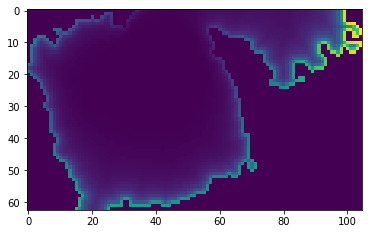

In [21]:
plt.imshow(rdt)

In [7]:
rp = regionprops(cell_seg)
rtc = cell_seg[spots['1'], spots['0']]
rtn = nucl_seg[spots['1'], spots['0']]

In [9]:
rtc

array([26, 21, 76, ...,  0, 32,  0], dtype=uint8)

In [10]:
rtn

array([ 0, 21,  0, ...,  0,  0,  0], dtype=uint8)